In [87]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [88]:
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenEyes_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenMouth_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/RaiseCheek_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlySurprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlyBodyMotion_0_Raw_0.bin"
# adc_data_path = "D:\\Subjects\\S2\\Neutral_10_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise0.5m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Standing_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/empty_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&surprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&alwaysmove_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_sit_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_body_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_body_move_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_head_move_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_always_surprise_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m/Joy_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m/Surprise_0_Raw_0.bin"
# adc_data_path = "D:/Subjects/S0/joy_1_Raw_0.bin"
adc_data_path = "D:/Subjects/300cm_30d/Surprise_5_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m/Neutral_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_stand/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_ground/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Joy_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Joy_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People_3/Joy_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_ground/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_always_surprise_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_ground_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/ground_1m_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/ground_1m_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise1m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/SurpriseAndBodyMotion_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing2ground_0_Raw_0.bin"

In [89]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 5
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [90]:
# (1) Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# (1) processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data)
range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(300, 32, 12, 256)


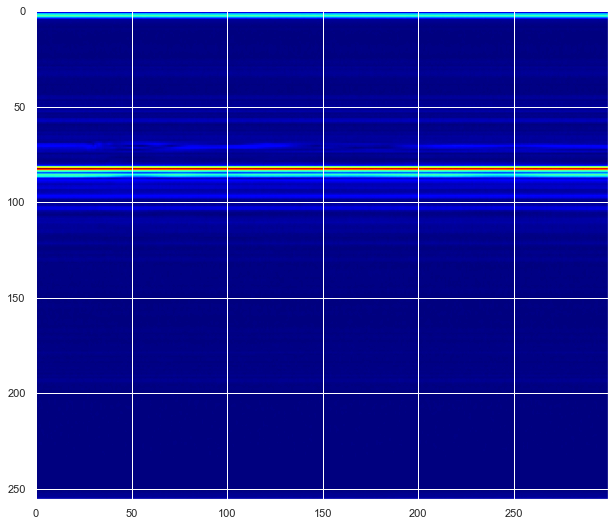

In [91]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))

range_plot_data = np.mean(range_data[:,15,:,:],axis=(1))

axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

# range doppler processing


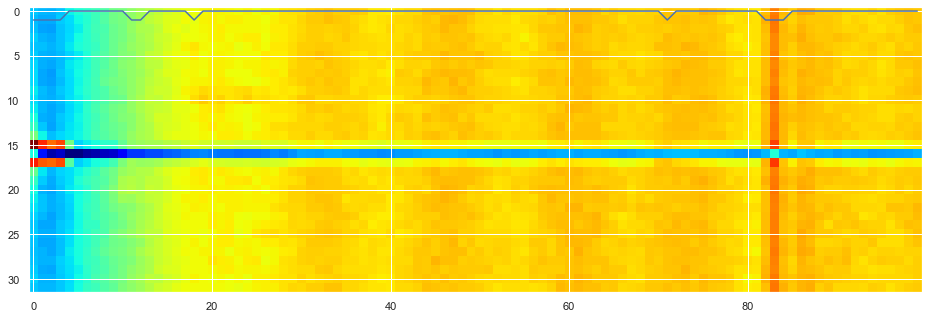

In [94]:
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
# det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
# det_matrix_vis = np.angle(det_matrix_vis)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
# det_matrix_vis_mean = det_matrix_vis[54, :, :]
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=2)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

# plt.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)
axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))






In [95]:
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

[11 12 18 71 82 83 84]


In [33]:
bin_start = detect_pos[0]
bin_end = detect_pos[-4]
print("start {}, end {}".format(bin_start, bin_end))

# bin_start = 28
# bin_end = 33
num_vec, steering_vec = dsp.gen_steering_vec(ANGLE_RANGE_AZI, ANGLE_RES_AZI, VIRT_ANT_AZI)

start 8, end 10


In [30]:
aoa_input = np.transpose(aoa_input, (0,3,2,1))
# aoa_input = aoa_input
# aoa_input = np.concatenate((aoa_input[:, :16, :, :], aoa_input[:, 17:, :, :]), axis=1)
aoa_input.shape

(300, 32, 12, 256)

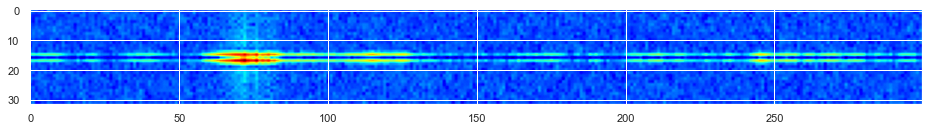

In [31]:
#micro doppler plot
d_start = 10
d_end = 11
fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
det_matrix_vis_mean = np.mean(det_matrix_vis[:, d_start:d_end, :], axis=1)
axes3.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)


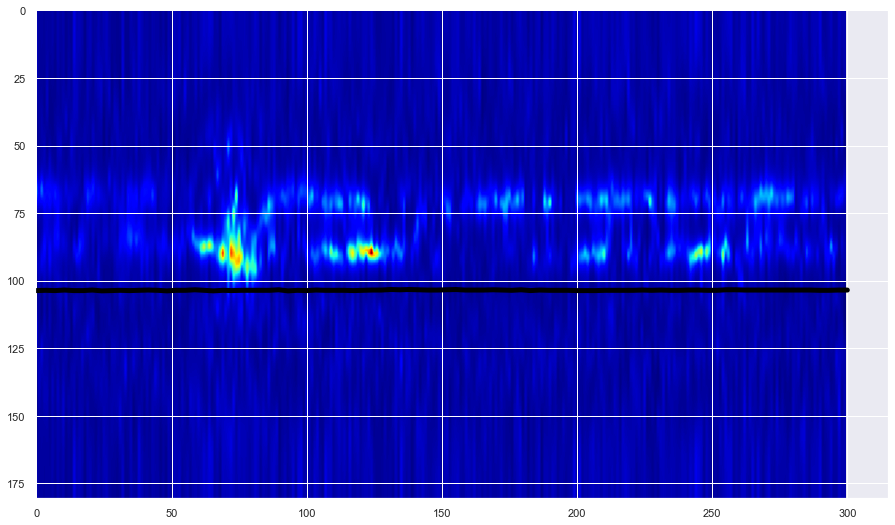

In [34]:
fig1, axes1 = plt.subplots(1, 1, figsize=(16, 9))
time_angle = np.zeros((ANGLE_BINS_AZI, 300))

# noise_data = np.random.normal(loc= 0, scale=20, size= (300,32,12,256))

# range_data += noise_data


for i in range(0, 300):
    for r in range(bin_start, bin_end):
        # chirp_data = np.mean(va_data[5, :, VIRT_ANT_AZI_INDEX, i:i + 1], axis=-1)
        chirp_data = aoa_input[i, :, VIRT_ANT_AZI_INDEX, r]
        # chirp_data = range_data[i, :, VIRT_ANT_AZI_INDEX, r]
        # chirp_data = np.angle(chirp_data)
        # steering_vec = np.angle(steering_vec)
        # chirp_data = va_data[50, :, VIRT_ANT_AZI_INDEX, i]
        # time_angle[:, i] += music.aoa_music_1D(steering_vec, chirp_data, 1)

        # capon beamformer
        capon_angle, beamWeights = dsp.aoa_capon(chirp_data, steering_vec, magnitude=True)
        time_angle[:, i] = time_angle[:, i] + capon_angle

    # music_specturm = music.aoa_root_music_1D(steering_vec, chirp_data, 1)
    # music_specturm = music.aoa_esprit(steering_vec.T, chirp_data, 2, 2)

#
# np.save("C:/Users/Zber/Desktop/Subjects/Test/empty_data", time_angle)
# empty_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/empty_data.npy")

# new_angle = time_angle-empty_angle

# fig, axes = plt.subplots(1, 1, figsize=(50, 90))
# axes.imshow(new_angle, cmap=plt.cm.jet)

axes1.imshow(time_angle, cmap=plt.cm.jet)


# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_1m_sit.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_sit_1m_move.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_stand_1m_move.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_stand_1m_head_move.npy")
image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_ground_1m_1.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_sit_1m_3.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/image_angle_standing_1.npy")
# image_angle = np.load("C:/Users/Zber/Desktop/Subjects/Test/Stand_Joy_0.npy")

image_angle = (image_angle - 35 + 90) / ANGLE_RES_AZI
angle = image_angle-2
x = np.linspace(0, 300, len(angle))
axes1.plot(x, angle, c="black", lw=5)

C:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


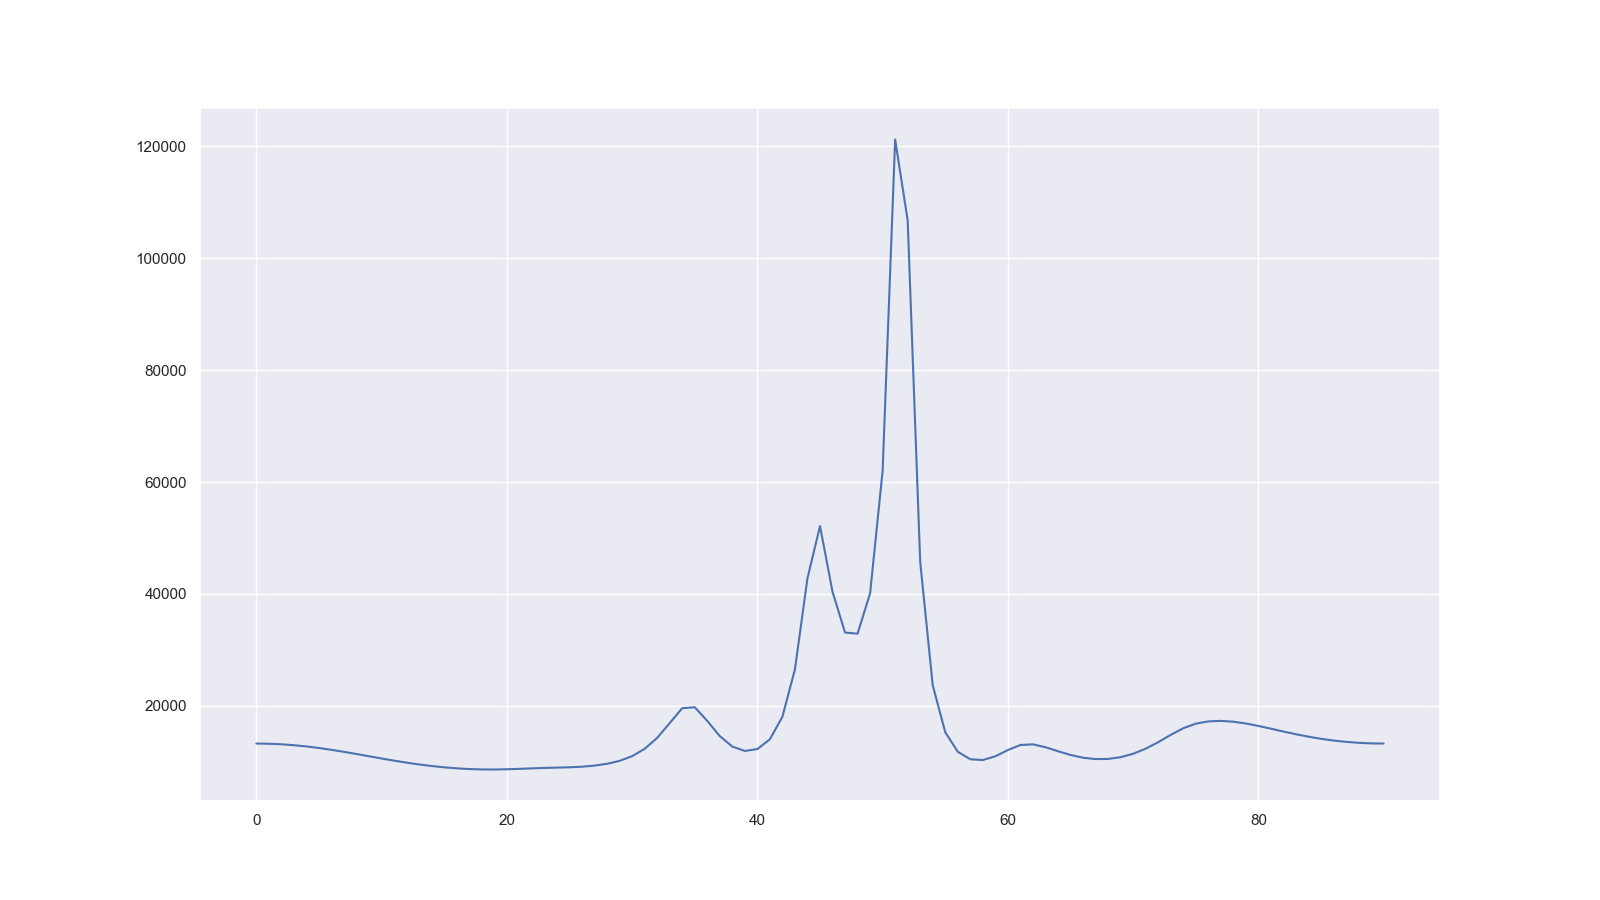

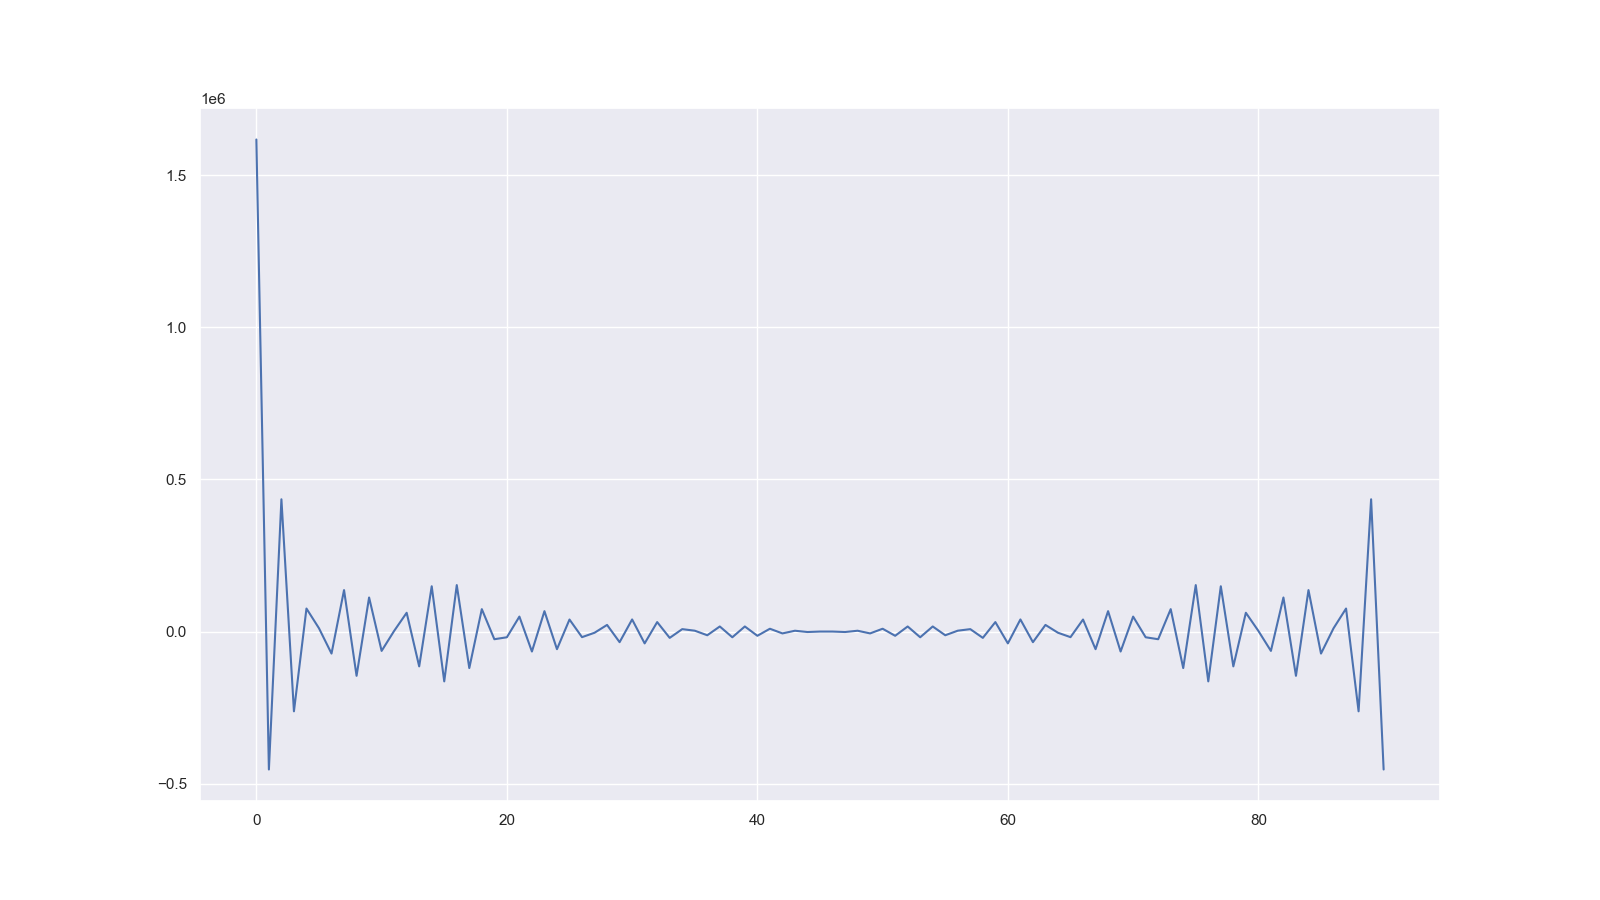

In [51]:
signal = np.mean(time_angle[:, 80:90], axis=-1)
fig2, axes2 = plt.subplots(1, 1, figsize=(16, 9))
axes2.plot(signal)


fft_signal = np.fft.fft(signal)

fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
axes3.plot(fft_signal)





[  5420.28257354  16077.25353466  26734.22449579  37391.19545692
  48048.16641805  58705.13737918  69362.10834031  80019.07930144
  90676.05026256 101333.02122369 111989.99218482 122646.96314595
 133303.93410708 143960.90506821 154617.87602934 165274.84699047
 175931.81795159 186588.78891272 197245.75987385 207902.73083498
 218559.70179611 229216.67275724 239873.64371837 250530.61467949
 261187.58564062 271844.55660175 282501.52756288 293158.49852401
 303815.46948514 314472.44044627]


(array([199.,  52.,  28.,  11.,   4.,   3.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  5420.28257354,  16077.25353466,  26734.22449579,  37391.19545692,
         48048.16641805,  58705.13737918,  69362.10834031,  80019.07930144,
         90676.05026256, 101333.02122369, 111989.99218482, 122646.96314595,
        133303.93410708, 143960.90506821, 154617.87602934, 165274.84699047,
        175931.81795159, 186588.78891272, 197245.75987385, 207902.73083498,
        218559.70179611, 229216.67275724, 239873.64371837, 250530.61467949,
        261187.58564062, 271844.55660175, 282501.52756288, 293158.49852401,
        303815.46948514, 314472.44044627]),
 <BarContainer object of 29 artists>)

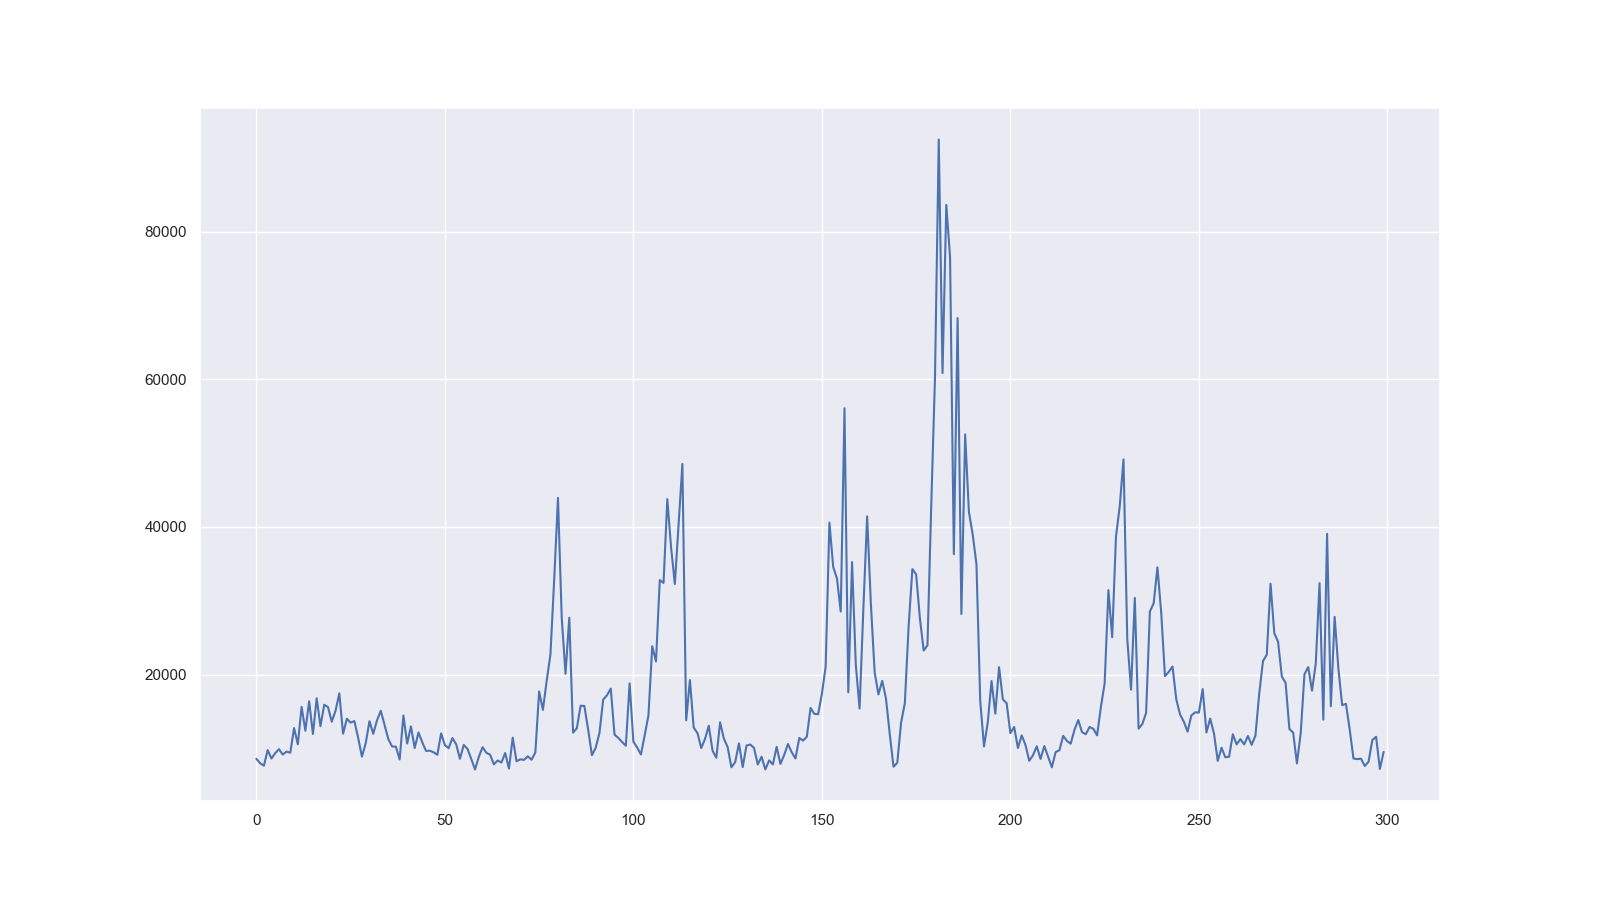

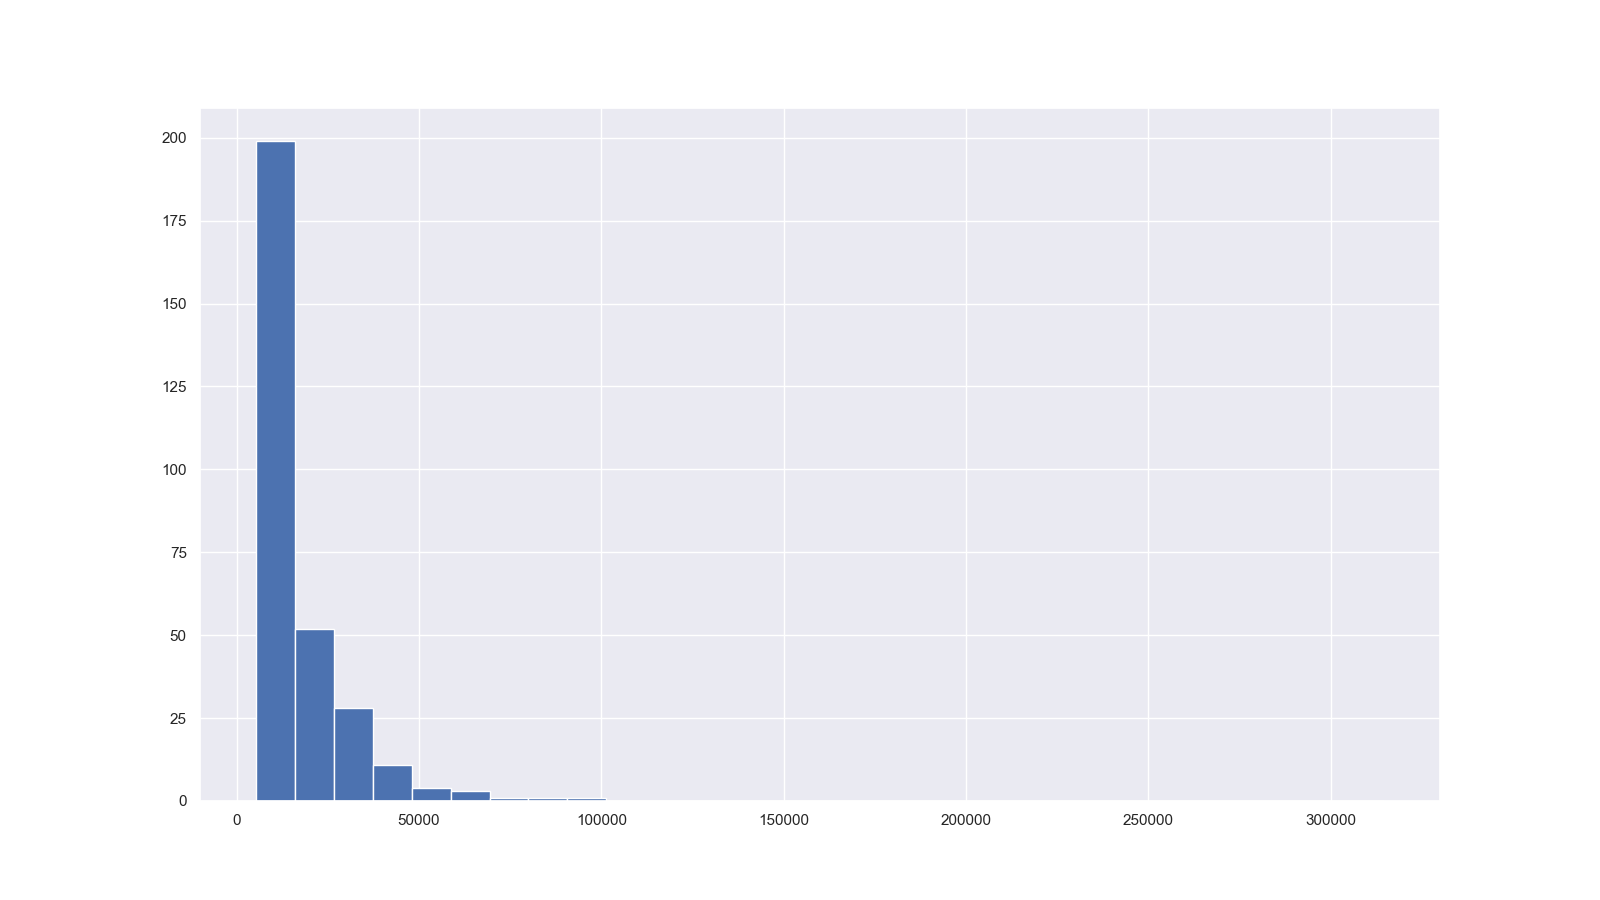

In [57]:
sig = time_angle[35, ]
fig4, axes4 = plt.subplots(1, 1, figsize=(16, 9))
axes4.plot(sig)

# hist_sig = np.histogram(sig, bins=20)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
# sig[sig<0.7] =0
min = np.min(time_angle)
max = np.max(time_angle)
bins = np.linspace(min, max, 30)
print(bins)
axes5.hist(sig, bins=bins)


[  5420.28257354  16077.25353466  26734.22449579  37391.19545692
  48048.16641805  58705.13737918  69362.10834031  80019.07930144
  90676.05026256 101333.02122369 111989.99218482 122646.96314595
 133303.93410708 143960.90506821 154617.87602934 165274.84699047
 175931.81795159 186588.78891272 197245.75987385 207902.73083498
 218559.70179611 229216.67275724 239873.64371837 250530.61467949
 261187.58564062 271844.55660175 282501.52756288 293158.49852401
 303815.46948514 314472.44044627]


(array([ 7., 19., 32., 54., 79., 47., 31., 14.,  7.,  5.,  1.,  1.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([  5420.28257354,  16077.25353466,  26734.22449579,  37391.19545692,
         48048.16641805,  58705.13737918,  69362.10834031,  80019.07930144,
         90676.05026256, 101333.02122369, 111989.99218482, 122646.96314595,
        133303.93410708, 143960.90506821, 154617.87602934, 165274.84699047,
        175931.81795159, 186588.78891272, 197245.75987385, 207902.73083498,
        218559.70179611, 229216.67275724, 239873.64371837, 250530.61467949,
        261187.58564062, 271844.55660175, 282501.52756288, 293158.49852401,
        303815.46948514, 314472.44044627]),
 <BarContainer object of 29 artists>)

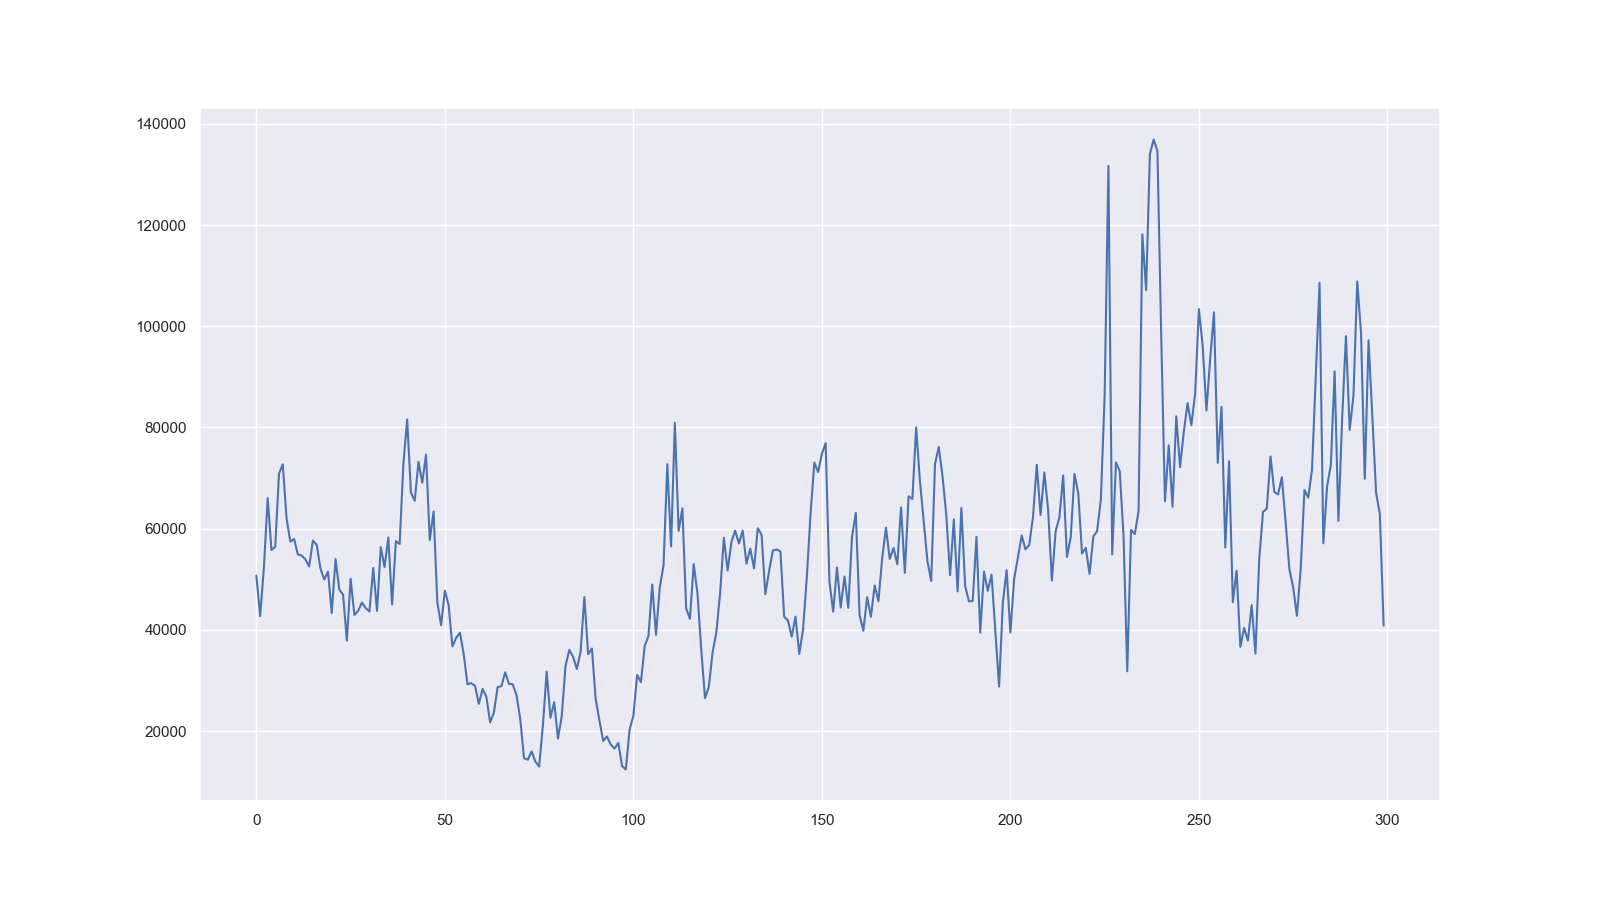

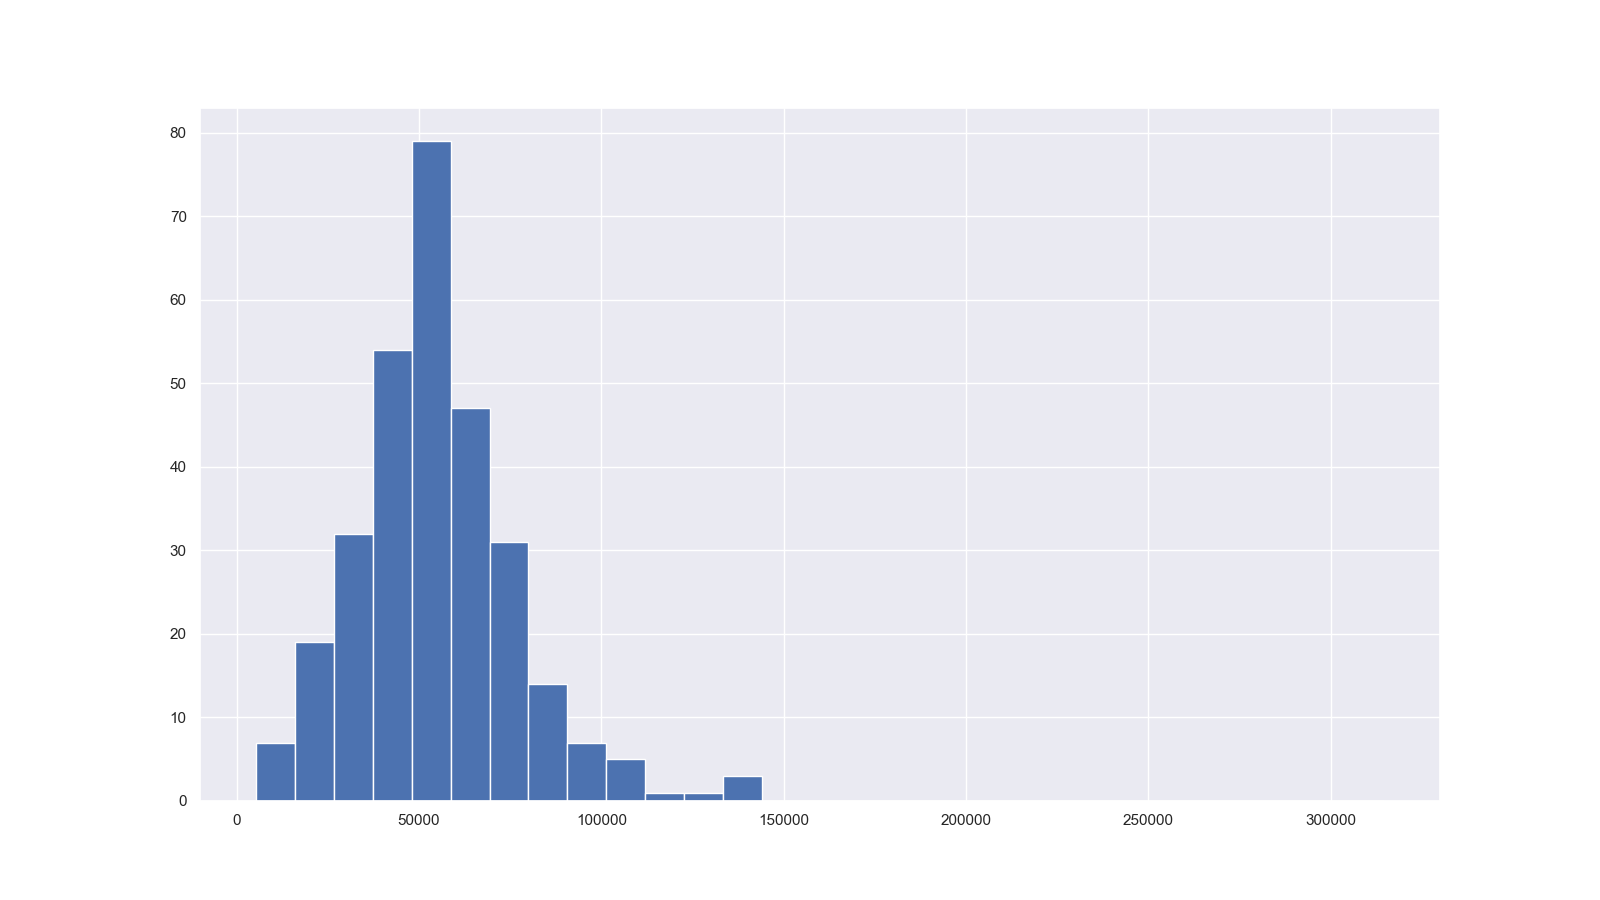

In [56]:
sig = time_angle[47, ]
fig4, axes4 = plt.subplots(1, 1, figsize=(16, 9))
axes4.plot(sig)

# hist_sig = np.histogram(sig, bins=20)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
# sig[sig<0.7] =0
min = np.min(time_angle)
max = np.max(time_angle)
bins = np.linspace(min, max, 30)
print(bins)
axes5.hist(sig, bins=bins)

# sig_fft  = np.fft.fft(sig)
# axes5.plot(sig_fft)


In [8]:
np.save("C:/Users/Zber/Desktop/Subjects/Test/music_time_angle_sit_3", time_angle)

In [ ]:
signal = time_angle[ : , 100:200]
noise_window = 10
min = np.min(signal)
max = np.max(signal)
bins = np.linspace(min, max, 30)
bin_size = len(bins)
n_order = 5



def get_frame(signal, a):
    return signal[a]


class LTSD():
    def __init__(self, x, winsize, window, order):
        self.signal = x
        self.winsize = winsize
        self.window = window
        self.order = order
        self.amplitude = {}
        self.noise_size = 10
        self.windownum = len(x)
        self.bin

    def get_amplitude(self, signal, l):
        if l in self.amplitude.keys():
            return self.amplitude[l]
        else:
            # amp = np.abs(np.fft.fft(get_frame(signal, self.winsize, l) * self.window))
            amp = np.hist(get_frame(self.signal, l))
            self.amplitude[l] = amp
            return amp

    def compute_noise_avg_spectrum(self):
        avgamp = np.zeros(self.winsize)
        for l in range(self.noise_size):
            avgamp += np.hist(get_frame(self.signal,  l))
        return avgamp / float(self.noise_size)

    def compute(self):
        ltsds = np.zeros(self.windownum)
        # Calculate the average noise spectrum amplitude based　on 20 frames in the head parts of input signal.
        self.avgnoise = self.compute_noise_avg_spectrum(self.signal[0:self.winsize * 20]) ** 2
        for l in range(self.windownum):
            ltsds[l] = self.ltsd(self.signal, l, 5)
        return ltsds

    def ltse(self, l):
        maxmag = np.zeros(self.winsize)
        for idx in range(l - self.order, l + self.order + 1):
            amp = self.get_amplitude(self.signal, idx)
            maxamp = np.maximum(maxmag, amp)
        return maxamp

    def ltsd(self, l):
        if l < self.order or l + self.order >= self.windownum:
            return 0
        return np.sum(self.ltse(self.signal, l, self.order) ** 2 / self.avgnoise) / float(len(self.avgnoise))